## Практическая работа №1

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import json
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.sentiment import SentimentIntensityAnalyzer

### Загрузка ресурсов для NLTK

In [53]:
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('vader_lexicon')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\olegs\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\olegs\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\olegs\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\olegs\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\olegs\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

### Загрузка данных

Для создания набора данных использовалась программа реализованная в первом семестре в рамках курса "Технологии извлечения знаний". Данная программа позволяет отчищать и парсить  информацию о композициях указанного артиста. Информация включает в себя: название, дату релиза, название альбома, просмотры страницы (на сайте Genius) и текст самой песни.

In [54]:
with open("data/ID_cleaned_songs.json", "r", encoding="utf-8") as f:
    songs = json.load(f)

df = pd.DataFrame(songs)
print(f"Найдено песен: {len(df)}")
df.head()

Найдено песен: 100


,title,date,album_name,pageviews,lyrics
0,Believer,"February 1, 2017",Evolve (Japanese Edition),7988349,"Second things second, don't you tell me what y..."
1,Thunder,"April 27, 2017",Evolve (Japanese Edition),2557981,"Thunder, thunder, thunder, thun—\nThunder, th-..."
2,Demons,"January 23, 2013",Night Visions (Expanded Edition) [Super Deluxe],2252444,"I wanna hide the truth, I wanna shelter you\nB..."
3,Enemy,"October 28, 2021",Mercury - Acts 1 & 2 (Japanese Edition),1690764,I wake up to the sounds of the silence that al...
4,Radioactive,"February 14, 2012",Night Visions (Expanded Edition) [Super Deluxe],1681174,I'm waking up to ash and dust\nI wipe my brow ...


Так как в рамках данной практической работы на интересует только текст самих песен, то столбцы date, album_name и  pageviews будут отчищены. 

In [55]:
df = df.drop(['date', 'album_name', 'pageviews'], axis=1)
df.head()

,title,lyrics
0,Believer,"Second things second, don't you tell me what y..."
1,Thunder,"Thunder, thunder, thunder, thun—\nThunder, th-..."
2,Demons,"I wanna hide the truth, I wanna shelter you\nB..."
3,Enemy,I wake up to the sounds of the silence that al...
4,Radioactive,I'm waking up to ash and dust\nI wipe my brow ...


### Реализация text_cleaner
Следующим шагом необходимо реализовать функцию выполняющую токенизацию и нормализацию текста (очистка, стоп-слова, лемматизация)

In [56]:
def clean_text(text):
    tokens = word_tokenize(text.lower())
    tokens = [i for i in tokens if i.isalpha()]
    tokens = [j for j in tokens if j not in stopwords.words('english')]
    
    lemmatizer = WordNetLemmatizer()
    lemmas = [lemmatizer.lemmatize(j) for j in tokens]
    return " ".join(lemmas)

Пример работы функции:

In [57]:
example = df['lyrics'].iloc[0]
print(clean_text(example)[:52])

second thing second tell think could one sail master


### Реализация sentiment_analysis
В данном блоке представлена реализация анализа тональности текста с помощью VADER

In [58]:
def analyze_sentiment(text):
    
    sia = SentimentIntensityAnalyzer()
    return sia.polarity_scores(text)

Пример работы:

In [59]:
print(analyze_sentiment("I'm extremely sorry I didn't submit my work on time, I'm sorry."))

{'neg': 0.261, 'neu': 0.739, 'pos': 0.0, 'compound': -0.2928}


### Применение функций к песням
После того как все необходимый функции были реализованы, можно приступить к их применению

In [60]:
df['clean_lyrics'] = df['lyrics'].apply(lambda x: clean_text(str(x)))
df['sentiment'] = df['lyrics'].apply(analyze_sentiment)
df['compound'] = df['sentiment'].apply(lambda x: x['compound'])

### Определение метки
Коэффициенты для определения метрики были подобраны экспериментальным путем

In [61]:
def get_label(score):
    if score >= 0.5:
        return "positive"
    elif score <= -0.5:
        return "negative"
    else:
        return "neutral"

df['label'] = df['compound'].apply(get_label)
df[['title', 'compound', 'label']].head()

,title,compound,label
0,Believer,-0.9906,negative
1,Thunder,0.4404,neutral
2,Demons,-0.9787,negative
3,Enemy,-0.9832,negative
4,Radioactive,0.9495,positive


### Результат
В качестве результата была представлена статистика и визуализация оценки настроения песен

In [62]:
counts = df['label'].value_counts()

print("Статистикa:")
print(counts)


Статистикa:
label
positive    55
negative    34
neutral     11
Name: count, dtype: int64


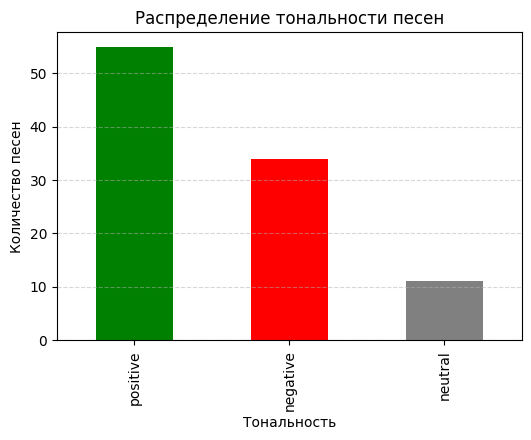

In [63]:
plt.figure(figsize=(6,4))
counts.plot(kind='bar', color=['green','red','gray'])
plt.title("Распределение тональности песен")
plt.xlabel("Тональность")
plt.ylabel("Количество песен")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()